# Init Bionic VTOL

In [1]:
include("../Flyonic.jl");
using .Flyonic;

using Rotations; # used for initial position

using ReinforcementLearning;
using StableRNGs;
using Flux;
using Flux.Losses;
using Random;
using IntervalSets;
using LinearAlgebra;
using Distributions;

using Plots;
using Statistics;

using BSON: @save, @load # save mode

In [2]:
create_visualization();

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/larissa/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


In [3]:
# indicates how many threads Julia was started with. This is important for the multi-threaded environment
Threads.nthreads()

1

# Create Reinforcement Learning Environment

In [4]:
mutable struct VtolEnv{A,T,ACT,R<:AbstractRNG} <: AbstractEnv # Parametric Constructor for a subtype of AbstractEnv
    action_space::A # action space
    observation_space::Space{Vector{ClosedInterval{T}}} # observation space
    state::Vector{T} # current state space
    action::ACT # action space
    done::Bool # done
    t::T # time
    rng::R # random number generator

    name::String # for multible environoments
    visualization::Bool # visualization
    realtime::Bool # realtime
    
    # Everything you need aditionaly can also go in here.
    x_W::Vector{T} # current position
    v_B::Vector{T} # velocity
    R_W::Matrix{T} # current rotation
    ω_B::Vector{T} # rotation velocitiy
    wind_W::Vector{T} # wind
    Δt::T # Δ time
    
    # Current Bonus / Target
    num_waypoints::Int # includig start point
    waypoints::Vector{Vector{T}}
    reached_goal::BitVector
    
    progress::T
    progress_prev::T
    current_point::Int
    reached_goal_in_step::Bool
    
    r_tol::T
end

In [5]:
# define a keyword-based constructor for the type declared in the mutable struct typedef. 
# It could also be done with the macro Base.@kwdef.
function VtolEnv(;
    rng = Random.GLOBAL_RNG, # Random number generation
    name = "vtol",
    visualization = false,
    realtime = false,
    kwargs... # let the function take an arbitrary number of keyword arguments 
)
    
    T = Float64; # explicit type which is used e.g. in state. Cannot be altered due to the poor matrix defininon.

    
    action_space = Space(
        ClosedInterval{T}[
            0.0..2.0, # propeller 1
            0.0..2.0, # propeller 2
            ], 
    )

    
    state_space = Space( # Three continuous values in state space.
        ClosedInterval{T}[
            # orientate yourself on the state space from the paper
            typemin(T)..typemax(T), # position along x
            typemin(T)..typemax(T), # position along z
            
            typemin(T)..typemax(T), # orientation along x
            typemin(T)..typemax(T), # orientation along z
            
            typemin(T)..typemax(T), # velocity along x BODY coordinates
            typemin(T)..typemax(T), # velocity along y BODY coordinates
            
            typemin(T)..typemax(T), # rotational velocity along z BODY coordinates
            
            typemin(T)..typemax(T), # position error along x (next gate - current position)
            typemin(T)..typemax(T), # position error along z (next gate - current position)
            
            typemin(T)..typemax(T), # way to next next gate x (next next gate - next gate)
            typemin(T)..typemax(T), # way to next next gate z (next next gate - next gate)
            # TODO: more points?
            ], 
    )
    
    num_waypoints = 3 # number of waypoints, includig start point
    waypoints = generate_trajectory(num_waypoints) # trajectory with num_waypoints waypoints (+ start point) 
    reached_goal = falses(num_waypoints)
    
    if visualization #visualizes VTOL and waypoints
        create_VTOL(name, actuators = true, color_vec=[1.0; 1.0; 0.6; 1.0]);
        visualize_waypoints(waypoints, 0.15)
    end

    environment = VtolEnv(
        action_space,
        state_space, 
        zeros(T, length(state_space)), # current state, needs to be extended
        rand(action_space), #initialization action
        false, # episode done 
        0.0, # time
        rng, # random number generator  
        
        name,
        visualization,
        realtime,
        
        zeros(T, 3), # x_W, current position
        zeros(T, 3), # v_B, velocity
        [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], # R_W, current rotation, Float64... so T needs to be Float64
        zeros(T, 3), # ω_B
        zeros(T, 3), # wind_W
        T(0.025), # Δt 
        
        num_waypoints, # includig start point
        waypoints, 
        reached_goal,
        
        0.0, # progress
        0.0, # progress_prev
        2, # current point
        false, # reached_goal_in_step
        
        0.5 # r_tol
    )
    
    
    reset!(environment)
    
    return environment
    
end;

Just for explanation:

1. A mutable Struct is created. A struct is a constructor and a constructor is a function that creates new objects.
2. A outer keyword-based constructor method is added for the type declared in the mutable struct typedef before.

So now we have a function with two methods. Julia will decide which method to call by multiple dispatch.

In [6]:
methods(VtolEnv)

# 2 methods for type constructor:
[1] VtolEnv(; rng, name, visualization, realtime, kwargs...) in Main at In[5]:3
[2] VtolEnv(action_space::A, observation_space::Space{Array{ClosedInterval{T}, 1}}, state::Vector{T}, action::ACT, done::Bool, t::T, rng::R, name::String, visualization::Bool, realtime::Bool, x_W::Vector{T}, v_B::Vector{T}, R_W::Matrix{T}, ω_B::Vector{T}, wind_W::Vector{T}, Δt::T, num_waypoints::Int64, waypoints::Array{Vector{T}, 1}, reached_goal::BitVector, progress::T, progress_prev::T, current_point::Int64, reached_goal_in_step::Bool, r_tol::T) where {A, T, ACT, R<:AbstractRNG} in Main at In[4]:2

# Define the RL interface

In [7]:
Random.seed!(env::VtolEnv, seed) = Random.seed!(env.rng, seed)
RLBase.action_space(env::VtolEnv) = env.action_space
RLBase.state_space(env::VtolEnv) = env.observation_space
RLBase.is_terminated(env::VtolEnv) = env.done
RLBase.state(env::VtolEnv) = env.state

In [8]:
function computeReward(env::VtolEnv{A,T}) where {A,T}
    
    norm_way = 0.0 # DEBUG: save in environment
    for i in 1:(env.num_waypoints - 1)
        norm_way += norm(env.waypoints[i] - env.waypoints[i + 1])
    end
    
    v_min = 0.0 # min velocity
    v_max = 3.0 # max velocity
    
#     k_v = 0.1 # factor for velocity penalty
#     norm_v = norm(env.v_B) # penalty for velocity
#     if (v_min <= norm_v && norm_v <= v_max) 
#         0.0
#     end
    
    
    k_wp = 5.0 * env.num_waypoints # factor for reached gate reward
    r_wp = 0.0 # reward for reached gate, TODO: change to gates later (when gates != waypoints)
    if env.reached_goal_in_step
        r_wp = exp(-norm(env.x_W - env.waypoints[env.current_point - 1])/env.r_tol)
    end
    
    k_ω = 0.01 # factor for too high body rate penalty
    norm_ω = norm(env.ω_B[3]) # penalty for body rate 

    k_s = 0.0 / norm_way #5.0 # factor for reached distance (overall) reward, TODO later add factor as in paper (p. 4)
    r_s = env.progress # reward for reached distance (overall)
    
    k_p = 5.0 * env.num_waypoints / norm_way;# factor for progress (between current position and last position) reward 
    r_p = (env.progress - env.progress_prev); # reward for progress (between current position and last position)

    return k_p * r_p + k_s * k_s + k_wp * r_wp - k_ω * norm_ω # - k_v * norm_v
    
end


RLBase.reward(env::VtolEnv{A,T}) where {A,T} = computeReward(env)

In [9]:
function RLBase.reset!(env::VtolEnv{A,T}) where {A,T}
    # Visualize initial state
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, [0.0; 0.0; 0.0; 0.0]);
    end
    
    env.x_W = [0.0; 0.0; 0.0];
    env.v_B = [0.0; 0.0; 0.0];
    env.R_W = Matrix(UnitQuaternion(RotZ(-pi/2.0)*RotY(-pi/2.0)*RotX(pi)));

    env.ω_B = [0.0; 0.0; 0.0];
    env.wind_W = [0.0; 0.0; 0.0];
    
    env.num_waypoints = 3; # includig start point
    env.waypoints = generate_trajectory(env.num_waypoints);
    env.reached_goal = falses(env.num_waypoints);
    env.reached_goal[1] = true; # set first point to reached (start point)
    
    env.current_point = 2;
    env.reached_goal_in_step = false;
    env.r_tol = 0.5;
    
    if env.visualization
        visualize_waypoints(env.waypoints, 0.15); # debug: other radius?
    end
    

    env.progress = 0.0;
    env.progress_prev = 0.0;
    
    
    env.state = [env.x_W[1]; # position along x
                 env.x_W[3]; # position along z
        
                 env.R_W[1,1]; # orientation along x
                 env.R_W[3,1]; # orientation along z
        
                 env.v_B[1]; # velocity along x BODY coordinates
                 env.v_B[2]; # velocity along y BODY coordinates  
        
                 env.ω_B[3]; # rotational velocity along z BODY coordinates
        
                 env.waypoints[2][1] - env.x_W[1]; # position error along x
                 env.waypoints[2][3] - env.x_W[3]; # position error along z
                 
                 0.0; # way to next next gate x (next next gate - next gate)
                 0.0] # way to next next gate z (next next gate - next gate)
    
    if env.num_waypoints >= 3
        env.state[10] = env.waypoints[3][1] - env.waypoints[2][1]; # way to next next gate x (next next gate - next gate)
        env.state[11] = env.waypoints[3][3] - env.waypoints[2][1]; # way to next next gate z (next next gate - next gate)
    end
        
    env.t = 0.0;
    env.action = [0.0, 0.0];
    env.done = false;
    
    nothing

end;

In [10]:
# defines a methods for a callable object.
# So when a VtolEnv object is created, it has this method that can be called
function (env::VtolEnv)(a)
    # TODO: set flaps later in 3D
    # set the propeller trust and the two flaps 2D case
    next_action = [a[1], a[2], 0.0, 0.0]
   
    _step!(env, next_action)
end

In [11]:
env = VtolEnv();

In [12]:
methods(env) # Just to explain which methods the object has

# 3 methods for callable object:
[1] (env::VtolEnv)(a) in Main at In[10]:3
[2] (env::AbstractEnv)(action) in ReinforcementLearningBase
[3] (env::AbstractEnv)(action, player) in ReinforcementLearningBase

In [13]:
function _step!(env::VtolEnv, next_action)
    # caluclate wind impact
    v_in_wind_B = vtol_add_wind(env.v_B, env.R_W, env.wind_W)
    # caluclate aerodynamic forces
    torque_B, force_B = vtol_model(v_in_wind_B, next_action, eth_vtol_param);
    # Limit to 2D
    force_B[3] = 0.0; # Body Z
    env.v_B[3] = 0.0;
    torque_B[1] = 0.0; torque_B[2] = 0.0;  # Body X and Y
    env.ω_B[1] = 0.0; env.ω_B[2] = 0.0;
    # integrate rigid body dynamics for Δt
    env.x_W, env.v_B, env.R_W, env.ω_B, time = rigid_body_simple(torque_B, force_B, env.x_W, env.v_B, env.R_W, env.ω_B, env.t, env.Δt, eth_vtol_param)
    
    
    
    
    env.reached_goal_in_step = false;
    if norm(env.x_W - env.waypoints[env.current_point]) < env.r_tol
        env.reached_goal_in_step = true;
        env.reached_goal[env.current_point] = true;
        env.current_point += 1;
    end
        
        
        
        
    # calculate progress on trajectory
    env.progress_prev = env.progress
    
    current_progress = 0.0
    line_segment, progress = calculate_progress(env.waypoints, env.x_W)
    for i in 2:(line_segment)
       current_progress +=  norm(env.waypoints[i] - env.waypoints[i - 1])  
    end
    current_progress += norm(env.waypoints[line_segment] - progress)
    
    env.progress = current_progress
    
    

    if env.realtime
        sleep(env.Δt) # TODO: just a dirty hack. this is of course slower than real time.
    end

    # Visualize the new state 
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, next_action)
        
        for i in eachindex(env.reached_goal)
            if env.reached_goal[i]
                create_sphere("fixgoal_$i", 0.2, color=RGBA{Float32}(1.0, 0.0, 0.0, 1.0));
                set_transform("fixgoal_$i", env.waypoints[i]);
            end
        end
    end
 
    env.t += env.Δt

    
    
    env.state[1] = env.x_W[1]; # position along x
    env.state[2] = env.x_W[3]; # position along z
    
    env.state[3] = env.R_W[1,1]; # orientation along x
    env.state[4] = env.R_W[3,1]; # orientation along z
    
    env.state[5] = env.v_B[1]; # velocity along x BODY coordinates
    env.state[6] = env.v_B[2]; # velocity along y BODY coordinates
    
    env.state[7] = env.ω_B[3];  # rotational velocity along z BODY coordinates
    
    
    if env.current_point <= env.num_waypoints
        env.state[8] = env.waypoints[env.current_point][1] - env.x_W[1]; # position error along x
        env.state[9] = env.waypoints[env.current_point][3] - env.x_W[3]; # position error along z
        
        if env.current_point <= env.num_waypoints - 1
            env.state[10] = env.waypoints[env.current_point + 1][1] - env.waypoints[env.current_point][1]; # way to next next gate x (next next gate - next gate)
            env.state[11] = env.waypoints[env.current_point + 1][3] - env.waypoints[env.current_point][3]; # way to next next gate z (next next gate - next gate)
        else
            env.state[10] = 0.0 # way to next next gate x (next next gate - next gate)
            env.state[11] = 0.0 # way to next next gate z (next next gate - next gate)
        end
    else
        env.state[8] = 0.0; # position error along x
        env.state[9] = 0.0; # position error along z
        env.state[10] = 0.0 # way to next next gate x (next next gate - next gate)
        env.state[11] = 0.0 # way to next next gate z (next next gate - next gate)
    end
        
    
    # Termination criteria
    # TODO: Use many termination criteria so that you do not train unnecessarily in wrong areas
    env.done = #true
        # After time... How fast is drone+Range of desired point
        # After reaching position (circle of r_tol)
        norm(env.ω_B) > 100.0 || 
        norm(env.v_B) > 100.0 || # stop if body is too fast # TODO: set higher later in fast training phase
        env.x_W[3] < -5.0 || # stop if body is below -5m
        env.t > env.num_waypoints * 10.0 ||# stop after 10s per point
        norm(env.x_W - progress) > 5.0 || # too far off the path 
        env.current_point > env.num_waypoints # all points reached
    nothing
end;

changed to 10s (5s before) per point and 5.0m too far off path (2.0 before)

In [14]:
RLBase.test_runnable!(env)

Test Summary:              | Pass  Total  Time
random policy with VtolEnv | 2000   2000  2.4s


Test.DefaultTestSet("random policy with VtolEnv", Any[], 2000, false, false, true, 1.670537362069329e9, 1.670537364464737e9)

Show an overview of the environment.

# Setup of a reinforcement learning experiment.

In [15]:
seed = 123    
rng = StableRNG(seed)
    N_ENV = 8
    UPDATE_FREQ = 1024
    
    
    # define multiple environments for parallel training
    env = MultiThreadEnv([
        # use different names for the visualization
        VtolEnv(; rng = StableRNG(hash(seed+i)), name = "vtol$i") for i in 1:N_ENV
    ])

MultiThreadEnv(8 x VtolEnv)

In [16]:
# Define the function approximator
# TODO: change architecture eventually 
    ns, na = length(state(env[1])), length(action_space(env[1]))
    approximator = ActorCritic(
                actor = GaussianNetwork(
                    pre = Chain(
                    Dense(ns, 128, tanh; initW = glorot_uniform(rng)),#
                    Dense(128, 128, tanh; initW = glorot_uniform(rng)),
                    ),
                    μ = Chain(Dense(128, na; initW = glorot_uniform(rng))),
                    logσ = Chain(Dense(128, na; initW = glorot_uniform(rng))),
                ),
                critic = Chain(
                    Dense(ns, 128, tanh; initW = glorot_uniform(rng)),
                    Dense(128, 128, tanh; initW = glorot_uniform(rng)),
                    Dense(128, 1; initW = glorot_uniform(rng)),
                ),
                optimizer = ADAM(1e-3),
            );

In [17]:
    agent = Agent( # A wrapper of an AbstractPolicy
        # AbstractPolicy: the policy to use
        # TODO: change eventually
        policy = PPOPolicy(;
                    approximator = approximator |> gpu,
                    update_freq=UPDATE_FREQ,
                    dist = Normal,
                    # For parameters visit the docu: https://juliareinforcementlearning.org/docs/rlzoo/#ReinforcementLearningZoo.PPOPolicy
                    ),
        
        # AbstractTrajectory: used to store transitions between an agent and an environment source
        trajectory = PPOTrajectory(;
            capacity = UPDATE_FREQ,
            state = Matrix{Float64} => (ns, N_ENV),
            action = Matrix{Float64} => (na, N_ENV),
            action_log_prob = Vector{Float64} => (N_ENV,),
            reward = Vector{Float64} => (N_ENV,),
            terminal = Vector{Bool} => (N_ENV,),
        ),
    );


┌ Info: The GPU function is being called but the GPU is not accessible. 
│ Defaulting back to the CPU. (No action is required if you want to run on the CPU).
└ @ Flux /home/larissa/.julia/packages/Flux/7nTyc/src/functor.jl:187


In [18]:
function saveModel(t, agent, env)
    model = cpu(agent.policy.approximator)   
    f = joinpath("./RL_models_l/", "vtol_2D_ppo_$t.bson") # TODO: evtl anpassen
    @save f model
    println("parameters at step $t saved to $f")
end;

In [19]:
function loadModel()
    f = joinpath("./RL_models_l/", "vtol_2D_ppo_trained_on_random_point.bson") # TODO: evtl anpassen
    @load f model
    return model
end;

In [20]:
function validate_policy(t, agent, env)
    run(agent.policy, test_env, StopAfterEpisode(1), episode_test_reward_hook)
    # the result of the hook
    println("test reward at step $t: $(episode_test_reward_hook.rewards[end])")
    
end;

episode_test_reward_hook = TotalRewardPerEpisode(;is_display_on_exit=false)
# create a env only for reward test
test_env = VtolEnv(;name = "testVTOL", visualization = true, realtime = true);

In [21]:
agent.policy.approximator = loadModel(); # TODO: un/comment

In [22]:
ReinforcementLearning.run(
    agent,
    env,
    StopAfterStep(2_500_000),
    ComposedHook(
        DoEveryNStep(saveModel, n=100_000), 
        DoEveryNStep(validate_policy, n=10_000)),
)

Progress:   0%|▏                                        |  ETA: 4:59:03

test reward at step 10000: -2.0888480817676456


Progress:   1%|▍                                        |  ETA: 2:53:09

test reward at step 20000: -0.610470659901308


Progress:   1%|▌                                        |  ETA: 2:09:13

test reward at step 30000: 7.863415297325599


Progress:   2%|▋                                        |  ETA: 1:48:25

test reward at step 40000: 20.393668587344486


Progress:   2%|▊                                        |  ETA: 1:37:49

test reward at step 50000: -1.9083591167490324


Progress:   2%|█                                        |  ETA: 1:30:19

test reward at step 60000: -1.9248353239331164


Progress:   3%|█▏                                       |  ETA: 1:24:16

test reward at step 70000: -0.8093865253329748


Progress:   3%|█▎                                       |  ETA: 1:19:26

test reward at step 80000: -1.815651333678338


Progress:   4%|█▌                                       |  ETA: 1:16:21

test reward at step 90000: 7.107554252755284


Progress:   4%|█▋                                       |  ETA: 1:13:38

parameters at step 100000 saved to ./RL_models_l/vtol_2D_ppo_100000.bson
test reward at step 100000: 4.33593202532676


Progress:   4%|█▊                                       |  ETA: 1:12:10

test reward at step 110000: 2.151850797766166


Progress:   5%|██                                       |  ETA: 1:09:43

test reward at step 120000: 6.4825957337376146


Progress:   5%|██▏                                      |  ETA: 1:07:36

test reward at step 130000: 18.129786225864752


Progress:   6%|██▎                                      |  ETA: 1:06:42

test reward at step 140000: 25.755261403469426


Progress:   6%|██▍                                      |  ETA: 1:05:05

test reward at step 150000: 8.992994624387437


Progress:   6%|██▋                                      |  ETA: 1:03:31

test reward at step 160000: 2.342050950203813


Progress:   7%|██▊                                      |  ETA: 1:02:15

test reward at step 170000: 11.48942816966507


Progress:   7%|███                                      |  ETA: 1:00:43

test reward at step 180000: 4.602746791707984


Progress:   8%|███▏                                     |  ETA: 0:59:41

test reward at step 190000: 6.873626664743279


Progress:   8%|███▎                                     |  ETA: 0:58:37

parameters at step 200000 saved to ./RL_models_l/vtol_2D_ppo_200000.bson
test reward at step 200000: 12.789661518615205


Progress:   8%|███▍                                     |  ETA: 0:58:16

test reward at step 210000: 6.380351286797615


Progress:   9%|███▋                                     |  ETA: 0:58:20

test reward at step 220000: 13.453735766390812


Progress:   9%|███▊                                     |  ETA: 0:57:25

test reward at step 230000: 20.484151326942875


Progress:  10%|███▉                                     |  ETA: 0:56:47

test reward at step 240000: 17.914847689059048


Progress:  10%|████▏                                    |  ETA: 0:55:59

test reward at step 250000: 7.955388812717698


Progress:  10%|████▎                                    |  ETA: 0:55:33

test reward at step 260000: 14.045059883096982


Progress:  11%|████▍                                    |  ETA: 0:54:50

test reward at step 270000: 19.759917015945856


Progress:  11%|████▋                                    |  ETA: 0:54:20

test reward at step 280000: 19.19878226883269


Progress:  12%|████▊                                    |  ETA: 0:54:03

test reward at step 290000: 10.065910922739258


Progress:  12%|████▉                                    |  ETA: 0:54:50

parameters at step 300000 saved to ./RL_models_l/vtol_2D_ppo_300000.bson


Progress:  12%|████▉                                    |  ETA: 0:55:14

test reward at step 300000: 19.800966683839782


Progress:  12%|█████▏                                   |  ETA: 0:54:27

test reward at step 310000: 21.07041791071029


Progress:  13%|█████▎                                   |  ETA: 0:53:56

test reward at step 320000: 13.98664213709119


Progress:  13%|█████▍                                   |  ETA: 0:53:32

test reward at step 330000: 25.048684549968918


Progress:  14%|█████▋                                   |  ETA: 0:53:04

test reward at step 340000: 27.242606795410808


Progress:  14%|█████▊                                   |  ETA: 0:52:37

test reward at step 350000: 20.64055280169691


Progress:  14%|█████▉                                   |  ETA: 0:52:11

test reward at step 360000: 26.91096956126021


Progress:  15%|██████                                   |  ETA: 0:51:44

test reward at step 370000: 18.96590350328218


Progress:  15%|██████▎                                  |  ETA: 0:51:23

test reward at step 380000: 20.348501653516365


Progress:  16%|██████▍                                  |  ETA: 0:51:03

test reward at step 390000: 18.955639725310487


Progress:  16%|██████▌                                  |  ETA: 0:50:44

parameters at step 400000 saved to ./RL_models_l/vtol_2D_ppo_400000.bson
test reward at step 400000: 20.019592372525604


Progress:  16%|██████▋                                  |  ETA: 0:50:26

test reward at step 410000: 19.925146309316414


Progress:  17%|██████▉                                  |  ETA: 0:49:57

test reward at step 420000: 25.23151305942752


Progress:  17%|███████                                  |  ETA: 0:49:39

test reward at step 430000: 25.6399733007816


Progress:  17%|███████▏                                 |  ETA: 0:49:23

test reward at step 440000: 26.216386109216955


Progress:  18%|███████▍                                 |  ETA: 0:49:01

test reward at step 450000: 19.346485760185036


Progress:  18%|███████▌                                 |  ETA: 0:48:45

test reward at step 460000: 27.55443052975736


Progress:  19%|███████▊                                 |  ETA: 0:48:21

test reward at step 470000: 25.608368790660403


Progress:  19%|███████▉                                 |  ETA: 0:48:05

test reward at step 480000: 19.75195791489926


Progress:  20%|████████                                 |  ETA: 0:47:51

test reward at step 490000: 27.95483977817965


Progress:  20%|████████▏                                |  ETA: 0:47:31

parameters at step 500000 saved to ./RL_models_l/vtol_2D_ppo_500000.bson
test reward at step 500000: 20.574078776491653


Progress:  20%|████████▍                                |  ETA: 0:47:24

test reward at step 510000: 20.22052678071417


Progress:  21%|████████▌                                |  ETA: 0:47:11

test reward at step 520000: 28.153795503870313


Progress:  21%|████████▋                                |  ETA: 0:46:51

test reward at step 530000: 19.71527752349343


Progress:  22%|████████▉                                |  ETA: 0:46:34

test reward at step 540000: 20.42391716295108


Progress:  22%|█████████                                |  ETA: 0:46:20

test reward at step 550000: 27.386721553193567


Progress:  22%|█████████▏                               |  ETA: 0:46:00

test reward at step 560000: 26.143074199322918


Progress:  23%|█████████▍                               |  ETA: 0:45:45

test reward at step 570000: 19.013402831977267


Progress:  23%|█████████▌                               |  ETA: 0:45:28

test reward at step 580000: 26.47253251070811


Progress:  24%|█████████▋                               |  ETA: 0:45:14

test reward at step 590000: 27.198811548275067


Progress:  24%|█████████▉                               |  ETA: 0:44:51

parameters at step 600000 saved to ./RL_models_l/vtol_2D_ppo_600000.bson
test reward at step 600000: 27.111182298480067


Progress:  24%|██████████                               |  ETA: 0:44:38

test reward at step 610000: 24.99478515305399


Progress:  25%|██████████▏                              |  ETA: 0:44:12

test reward at step 620000: 26.916700593929626


Progress:  25%|██████████▍                              |  ETA: 0:43:50

test reward at step 630000: 21.412064700495293


Progress:  26%|██████████▌                              |  ETA: 0:43:34

test reward at step 640000: 19.275986443187314


Progress:  26%|██████████▋                              |  ETA: 0:43:23

test reward at step 650000: 26.32779524387442


Progress:  26%|██████████▉                              |  ETA: 0:43:05

test reward at step 660000: 26.749574639761857


Progress:  27%|███████████                              |  ETA: 0:42:46

test reward at step 670000: 13.652064800345846


Progress:  27%|███████████▏                             |  ETA: 0:42:25

test reward at step 680000: 28.60266939571685


Progress:  27%|███████████▎                             |  ETA: 0:42:12

test reward at step 690000: 24.735920060441316


Progress:  28%|███████████▌                             |  ETA: 0:41:46

parameters at step 700000 saved to ./RL_models_l/vtol_2D_ppo_700000.bson
test reward at step 700000: 20.679693636416847


Progress:  28%|███████████▋                             |  ETA: 0:41:28

test reward at step 710000: 26.89802655078164


Progress:  29%|███████████▊                             |  ETA: 0:41:13

test reward at step 720000: 26.108703008144083


Progress:  29%|████████████                             |  ETA: 0:40:54

test reward at step 730000: 26.466276202885545


Progress:  30%|████████████▏                            |  ETA: 0:40:35

test reward at step 740000: 25.102349700256664


Progress:  30%|████████████▎                            |  ETA: 0:40:21

test reward at step 750000: 27.284073179887123


Progress:  30%|████████████▍                            |  ETA: 0:40:02

test reward at step 760000: 26.98417707934434


Progress:  31%|████████████▋                            |  ETA: 0:39:42

test reward at step 770000: 27.673763515403895


Progress:  31%|████████████▊                            |  ETA: 0:39:24

test reward at step 780000: 25.721409111077364


Progress:  32%|█████████████                            |  ETA: 0:39:03

test reward at step 790000: 25.677249319884037


Progress:  32%|█████████████▏                           |  ETA: 0:38:46

parameters at step 800000 saved to ./RL_models_l/vtol_2D_ppo_800000.bson
test reward at step 800000: 26.572083896181375


Progress:  32%|█████████████▎                           |  ETA: 0:38:29

test reward at step 810000: 25.07372709806377


Progress:  33%|█████████████▍                           |  ETA: 0:38:15

test reward at step 820000: 25.052745190354287


Progress:  33%|█████████████▋                           |  ETA: 0:37:55

test reward at step 830000: 25.836066788837478


Progress:  34%|█████████████▊                           |  ETA: 0:37:42

test reward at step 840000: 25.65796769684878


Progress:  34%|█████████████▉                           |  ETA: 0:37:22

test reward at step 850000: 26.219478622212115


Progress:  34%|██████████████▏                          |  ETA: 0:37:08

test reward at step 860000: 25.880710821383083


Progress:  35%|██████████████▎                          |  ETA: 0:36:51

test reward at step 870000: 26.43043168357987


Progress:  35%|██████████████▍                          |  ETA: 0:36:34

test reward at step 880000: 26.324627446136972


Progress:  36%|██████████████▌                          |  ETA: 0:36:20

test reward at step 890000: 26.904271114195605


Progress:  36%|██████████████▊                          |  ETA: 0:36:01

parameters at step 900000 saved to ./RL_models_l/vtol_2D_ppo_900000.bson


Progress:  36%|██████████████▊                          |  ETA: 0:36:17

test reward at step 900000: 22.56924221191377


Progress:  36%|██████████████▉                          |  ETA: 0:36:03

test reward at step 910000: 18.750106090665216


Progress:  37%|███████████████▏                         |  ETA: 0:35:44

test reward at step 920000: 27.35415019791108


Progress:  37%|███████████████▎                         |  ETA: 0:35:32

test reward at step 930000: 26.479374438057807


Progress:  38%|███████████████▍                         |  ETA: 0:35:12

test reward at step 940000: 25.592406137497665


Progress:  38%|███████████████▌                         |  ETA: 0:35:00

test reward at step 950000: 26.42444660814869


Progress:  38%|███████████████▊                         |  ETA: 0:34:40

test reward at step 960000: 29.494937491284986


Progress:  39%|███████████████▉                         |  ETA: 0:34:27

test reward at step 970000: 20.444654533332006


Progress:  39%|████████████████▏                        |  ETA: 0:34:08

test reward at step 980000: 27.139995244799476


Progress:  40%|████████████████▎                        |  ETA: 0:33:54

test reward at step 990000: 27.499250830120722


Progress:  40%|████████████████▍                        |  ETA: 0:33:39

parameters at step 1000000 saved to ./RL_models_l/vtol_2D_ppo_1000000.bson
test reward at step 1000000: 26.82413047308263


Progress:  40%|████████████████▌                        |  ETA: 0:33:22

test reward at step 1010000: 25.419204615094017


Progress:  41%|████████████████▊                        |  ETA: 0:33:08

test reward at step 1020000: 26.964239039585884


Progress:  41%|████████████████▉                        |  ETA: 0:32:51

test reward at step 1030000: 29.114729921776387


Progress:  41%|█████████████████                        |  ETA: 0:32:39

test reward at step 1040000: 25.682278990984077


Progress:  42%|█████████████████▎                       |  ETA: 0:32:20

test reward at step 1050000: 19.680132137005476


Progress:  42%|█████████████████▍                       |  ETA: 0:32:07

test reward at step 1060000: 25.02088738748911


Progress:  43%|█████████████████▌                       |  ETA: 0:31:51

test reward at step 1070000: 27.666659728332768


Progress:  43%|█████████████████▊                       |  ETA: 0:31:35

test reward at step 1080000: 25.92692008950941


Progress:  44%|█████████████████▉                       |  ETA: 0:31:19

test reward at step 1090000: 27.257098842078296


Progress:  44%|██████████████████                       |  ETA: 0:31:05

parameters at step 1100000 saved to ./RL_models_l/vtol_2D_ppo_1100000.bson
test reward at step 1100000: 27.50632522503075


Progress:  44%|██████████████████▎                      |  ETA: 0:30:49

test reward at step 1110000: 20.053793981912385


Progress:  45%|██████████████████▍                      |  ETA: 0:30:37

test reward at step 1120000: 26.80260506199211


Progress:  45%|██████████████████▌                      |  ETA: 0:30:24

test reward at step 1130000: 27.800492339670125


Progress:  46%|██████████████████▋                      |  ETA: 0:30:06

test reward at step 1140000: 26.831957314905402


Progress:  46%|██████████████████▉                      |  ETA: 0:29:51

test reward at step 1150000: 24.359420817772985


Progress:  46%|███████████████████                      |  ETA: 0:29:37

test reward at step 1160000: 25.917175297206324


Progress:  47%|███████████████████▏                     |  ETA: 0:29:21

test reward at step 1170000: 26.135189820052865


Progress:  47%|███████████████████▍                     |  ETA: 0:29:07

test reward at step 1180000: 24.89585967984989


Progress:  48%|███████████████████▌                     |  ETA: 0:28:52

test reward at step 1190000: 27.751804580297097


Progress:  48%|███████████████████▋                     |  ETA: 0:28:38

parameters at step 1200000 saved to ./RL_models_l/vtol_2D_ppo_1200000.bson
test reward at step 1200000: 27.584020164097918


Progress:  48%|███████████████████▉                     |  ETA: 0:28:24

test reward at step 1210000: 18.42803488828104


Progress:  49%|████████████████████                     |  ETA: 0:28:11

test reward at step 1220000: 26.07107381678913


Progress:  49%|████████████████████▏                    |  ETA: 0:27:58

test reward at step 1230000: 27.722906733376487


Progress:  50%|████████████████████▍                    |  ETA: 0:27:44

test reward at step 1240000: 28.706438635934195


Progress:  50%|████████████████████▌                    |  ETA: 0:27:29

test reward at step 1250000: 26.211924091367173


Progress:  50%|████████████████████▋                    |  ETA: 0:27:14

test reward at step 1260000: 27.497878721640177


Progress:  51%|████████████████████▊                    |  ETA: 0:27:02

test reward at step 1270000: 25.24307369882336


Progress:  51%|█████████████████████                    |  ETA: 0:26:44

test reward at step 1280000: 26.657697923509538


Progress:  52%|█████████████████████▏                   |  ETA: 0:26:30

test reward at step 1290000: 26.487658188431396


Progress:  52%|█████████████████████▍                   |  ETA: 0:26:16

parameters at step 1300000 saved to ./RL_models_l/vtol_2D_ppo_1300000.bson
test reward at step 1300000: 13.57249108344246


Progress:  52%|█████████████████████▌                   |  ETA: 0:26:02

test reward at step 1310000: 27.269530813971265


Progress:  53%|█████████████████████▋                   |  ETA: 0:25:48

test reward at step 1320000: 25.0997488960494


Progress:  53%|█████████████████████▊                   |  ETA: 0:25:35

test reward at step 1330000: 19.319132508363253


Progress:  54%|██████████████████████                   |  ETA: 0:25:21

test reward at step 1340000: 26.08609638425186


Progress:  54%|██████████████████████▏                  |  ETA: 0:25:06

test reward at step 1350000: 26.75957211563645


Progress:  54%|██████████████████████▎                  |  ETA: 0:24:52

test reward at step 1360000: 27.4259578103612


Progress:  55%|██████████████████████▌                  |  ETA: 0:24:41

test reward at step 1370000: 24.894839591148376


Progress:  55%|██████████████████████▋                  |  ETA: 0:24:25

test reward at step 1380000: 26.569400529397214


Progress:  56%|██████████████████████▊                  |  ETA: 0:24:13

test reward at step 1390000: 27.198699405648433


Progress:  56%|███████████████████████                  |  ETA: 0:23:59

parameters at step 1400000 saved to ./RL_models_l/vtol_2D_ppo_1400000.bson
test reward at step 1400000: 26.238218030391902


Progress:  56%|███████████████████████▏                 |  ETA: 0:23:46

test reward at step 1410000: 25.30263019287169


Progress:  57%|███████████████████████▎                 |  ETA: 0:23:32

test reward at step 1420000: 26.193346976978088


Progress:  57%|███████████████████████▍                 |  ETA: 0:23:20

test reward at step 1430000: 26.264001116946535


Progress:  58%|███████████████████████▋                 |  ETA: 0:23:05

test reward at step 1440000: 26.303780318105556


Progress:  58%|███████████████████████▊                 |  ETA: 0:22:51

test reward at step 1450000: 25.471871286080717


Progress:  58%|███████████████████████▉                 |  ETA: 0:22:38

test reward at step 1460000: 25.558345473844337


Progress:  59%|████████████████████████▏                |  ETA: 0:22:24

test reward at step 1470000: 26.980428383120397


Progress:  59%|████████████████████████▎                |  ETA: 0:22:10

test reward at step 1480000: 28.628544747231032


Progress:  60%|████████████████████████▍                |  ETA: 0:21:58

test reward at step 1490000: 25.946903103784827


Progress:  60%|████████████████████████▋                |  ETA: 0:21:45

parameters at step 1500000 saved to ./RL_models_l/vtol_2D_ppo_1500000.bson
test reward at step 1500000: 25.939236167619946


Progress:  60%|████████████████████████▊                |  ETA: 0:21:30

test reward at step 1510000: 27.657944123301647


Progress:  61%|████████████████████████▉                |  ETA: 0:21:16

test reward at step 1520000: 26.330059739422985


Progress:  61%|█████████████████████████                |  ETA: 0:21:07

LoadError: InterruptException:

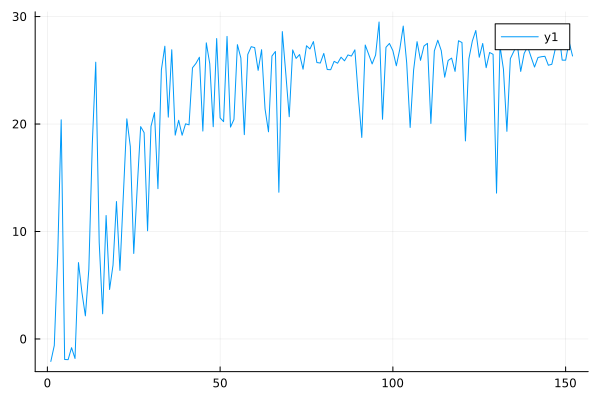

In [25]:
plot(episode_test_reward_hook.rewards)

In [26]:
close_visualization(); # closes the MeshCat visualization